In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import numpy as np
from rmab.utils import get_results_matching_parameters, filter_pareto_optimal, custom_reward, one_hot
from rmab.plots import plot_line_plot_parameter, plot_tradeoff_curve, process_two_parameter_data, process_one_parameter_data, process_zero_parameter_data, aggregate_data, aggregate_normalize_data
import seaborn as sns
import itertools 
from scipy import stats
from rmab.fr_dynamics import get_all_transitions
from rmab.omniscient_policies import random_policy
from rmab.simulator import RMABSimulator, run_heterogenous_policy
import random 

/usr0/home/naveenr/miniconda3/envs/food/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')


In [4]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.rcParams['savefig.bbox'] = 'tight'

## NeurIPS 2024 Plots

### Budget and Number of Arms

Text(48.972222222222214, 0.5, 'Reward vs. Greedy')

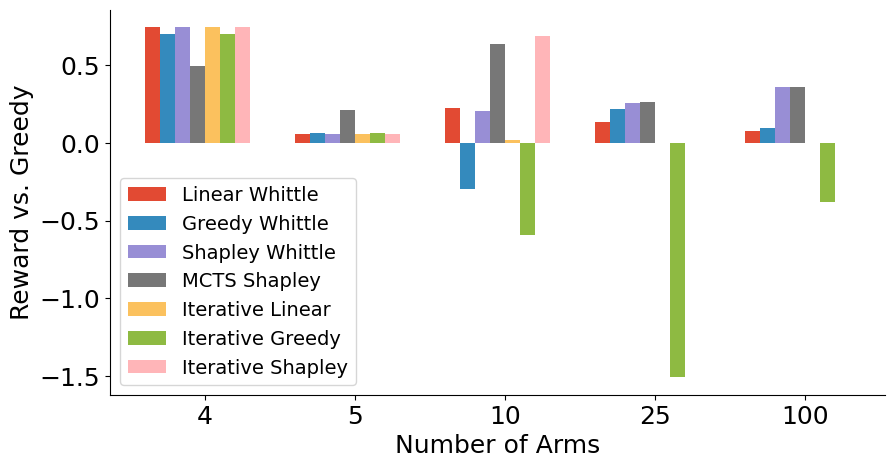

In [15]:
method_names = ['linear_whittle','greedy_whittle','shapley_whittle_custom','mcts_shapley','iterative_whittle','greedy_iterative_whittle','shapley_iterative_whittle']
nice_names = ["Linear Whittle","Greedy Whittle","Shapley Whittle","MCTS Shapley","Iterative Linear","Iterative Greedy","Iterative Shapley"]
n_arms = [4,5,10,25,100]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "n_k_variation"

    for n in n_arms:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': n//4, 'n_arms': n})
        results = aggregate_normalize_data(results,baseline="greedy")
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(n_arms))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend(loc="lower left")
plt.savefig("../../results/figures/num_arms.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(n_arms))))+width*len(method_names)/2,n_arms)
plt.xlabel("Number of Arms")
plt.ylabel("Reward vs. Greedy")

In [18]:
[i['parameters']['budget'] for i in get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5,'n_arms': 10,'budget': 10})]

[10, 10, 10]

### Baselines

Text(56.222222222222214, 0.5, 'Avg. Discounted Reward')

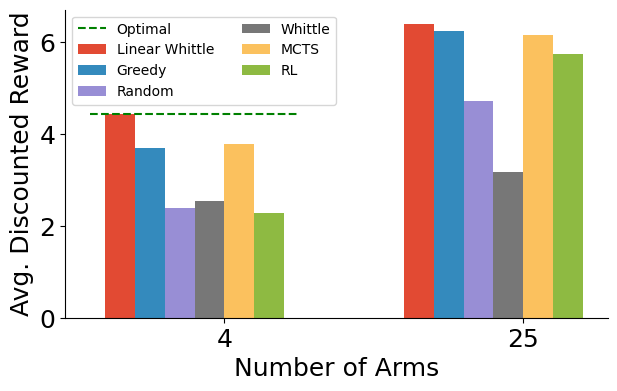

In [21]:
method_names = ['linear_whittle','greedy','random','whittle_activity','mcts','dqn_step','optimal']
nice_names = ["Linear Whittle","Greedy","Random","Whittle","MCTS","RL","Optimal"]
n_arms = [4,25]
width = 0.1
plt.figure(figsize=(7,4))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "baselines/all"

    for n in n_arms:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': n//4, 'n_arms': n})
        results = aggregate_data(results)
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    
    if m == 'optimal':
        plt.hlines(score_by_n[0],-0.1,0.6,colors='green',linestyles='dashed',label='Optimal')

    else:
        plt.bar(np.array(list(range(len(n_arms))))+i*width,score_by_n,width=width,label=nice_names[i])

plt.legend(loc='upper left',fontsize=10,ncol=2)
plt.savefig("../../results/figures/num_arms.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(n_arms))))+width*len(method_names)/2,n_arms)
plt.xlabel("Number of Arms")
plt.ylabel("Avg. Discounted Reward")

### Max and Subset Reward

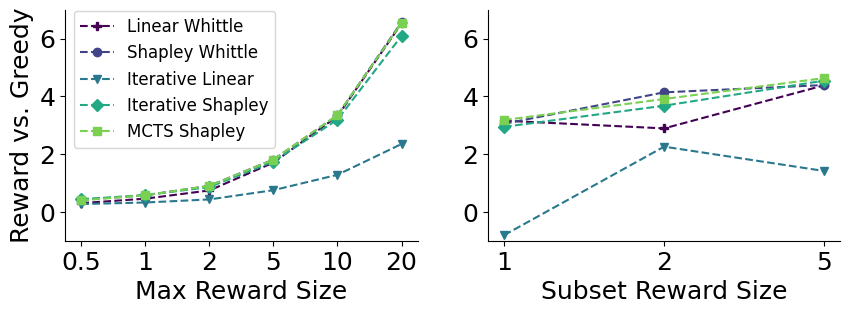

In [165]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_shapley']
nice_names = ["Linear Whittle","Shapley Whittle","Iterative Linear","Iterative Shapley","MCTS Shapley"]
subset_sizes = [0.5,1,2,5,10,20]
width = 0.1
# plt.figure(figsize=(5,3))
color_palette = plt.cm.viridis(np.linspace(0, 1, 6))
shapes = ['P','o','v','D','s']

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "reward_variation/max_reward"

    for subset_size in subset_sizes:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 10//2, 'n_arms': 10,'arm_set_high': subset_size})
        results = aggregate_normalize_data(results,baseline="greedy")
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    
    # plt.fill_between(list(range(len(subset_sizes))), np.array(score_by_n) - np.array(std_by_n), np.array(score_by_n) + np.array(std_by_n), alpha=0.1,  color=color_palette[i])
    axs[0].plot(list(range(len(subset_sizes))),score_by_n,'{}--'.format(shapes[i]),color=color_palette[i],label=nice_names[i])
axs[0].set_ylim([-1,7])
axs[0].legend(loc="upper left",bbox_to_anchor=(0,1.03),fontsize=12)
axs[0].set_xlabel("Max Reward Size")
axs[0].set_xticks(list(range(len(subset_sizes))),subset_sizes)
axs[0].set_ylabel("Reward vs. Greedy")

subset_sizes = [10//8,10//4,10//2]
width = 0.1

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "reward_variation/subset_reward"

    for subset_size in subset_sizes:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 10//2, 'n_arms': 10,'arm_set_low': subset_size})
        results = aggregate_normalize_data(results,baseline="greedy")
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    # plt.fill_between(list(range(len(subset_sizes))), np.array(score_by_n) - np.array(std_by_n), np.array(score_by_n) + np.array(std_by_n), alpha=0.1,  color=color_palette[i])
    axs[1].plot(list(range(len(subset_sizes))),score_by_n,'{}--'.format(shapes[i]),color=color_palette[i],label=nice_names[i])
axs[1].set_ylim([-1,7])
axs[1].set_xlabel("Subset Reward Size")
axs[1].set_xticks(list(range(len(subset_sizes))),subset_sizes)
plt.savefig("../../results/figures/max_subset.pdf",dpi=300, bbox_inches='tight')


### Impact of Linearity

In [199]:
params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2,'n_arms': 10, 'arm_set_low': 6,'prob_distro': 'fixed'}
results = get_results_matching_parameters(dataset,"",params)
results[2]['ratio']

0.75

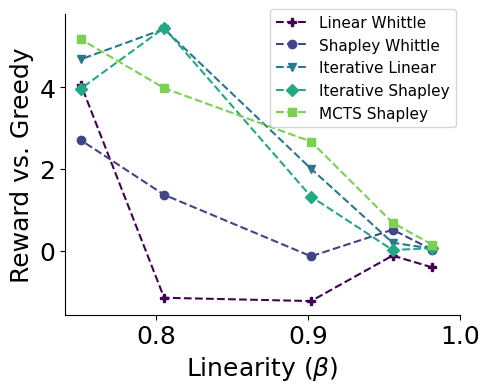

In [266]:
method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_shapley']
nice_names = ["Linear Whittle","Shapley Whittle","Iterative Linear","Iterative Shapley","MCTS Shapley"]

arm_sizes = [1,2,4,8,10]

plt.figure(figsize=(5,4))

x_axis = []
plots_by_method = {} 
std_by_method = {}
for i in method_names:
    plots_by_method[i] = []
    std_by_method[i] = []

for arm in arm_sizes:
    params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2,'n_arms': 10, 'arm_set_low': arm,'prob_distro': 'fixed'}
    dataset = "reward_variation/subset_reward"
    results = get_results_matching_parameters(dataset,"",params)
    results = aggregate_normalize_data(results,baseline="greedy")
    
    x_axis.append(results['ratio'][0])
    for method_name in method_names:
        plots_by_method[method_name].append(results['{}_reward'.format(method_name)][0])
        std_by_method[method_name].append(results['{}_reward'.format(method_name)][1])

for i,m in enumerate(method_names):
    # plt.fill_between(x_axis, np.array(plots_by_method[m]) - np.array(std_by_method[m]), np.array(plots_by_method[m]) + np.array(std_by_method[m]), alpha=0.2,  color=color_palette[i])
    plt.plot(x_axis,plots_by_method[m],'{}--'.format(shapes[i]),color=color_palette[i],label=nice_names[i])
plt.xlim([0.74,1.0])
plt.xlabel("Linearity ($\\beta$)")
plt.ylabel("Reward vs. Greedy")
plt.legend(fontsize=11,bbox_to_anchor=(0.5,0.6))
plt.tight_layout()
plt.savefig("../../results/figures/linearity_budget_2.pdf",dpi=300, bbox_inches='tight')

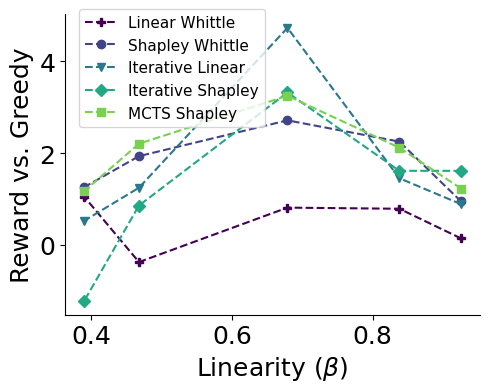

In [269]:
method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_shapley']
nice_names = ["Linear Whittle","Shapley Whittle","Iterative Linear","Iterative Shapley","MCTS Shapley"]

arm_sizes = [1,2,4,8,10]
plt.figure(figsize=(5,4))

x_axis = []
plots_by_method = {} 
std_by_method = {}
for i in method_names:
    plots_by_method[i] = []
    std_by_method[i] = []

for arm in arm_sizes:
    params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 5,'n_arms': 10, 'arm_set_low': arm,'prob_distro': 'fixed'}
    dataset = "reward_variation/subset_reward"
    results = get_results_matching_parameters(dataset,"",params)
    results = aggregate_normalize_data(results,baseline="greedy")
    
    x_axis.append(results['ratio'][0])
    for method_name in method_names:
        plots_by_method[method_name].append(results['{}_reward'.format(method_name)][0])
        std_by_method[method_name].append(results['{}_reward'.format(method_name)][1])

for i,m in enumerate(method_names):
    # plt.fill_between(x_axis, np.array(plots_by_method[m]) - np.array(std_by_method[m]), np.array(plots_by_method[m]) + np.array(std_by_method[m]), alpha=0.2,  color=color_palette[i])
    plt.plot(x_axis,plots_by_method[m],'{}--'.format(shapes[i]),color=color_palette[i],label=nice_names[i])
plt.xlabel("Linearity ($\\beta$)")
plt.ylabel("Reward vs. Greedy")
plt.legend(fontsize=11,bbox_to_anchor=(0.5,0.6))
plt.tight_layout()
plt.savefig("../../results/figures/linearity_budget_5.pdf",dpi=300, bbox_inches='tight')

### MCTS vs. Iterative Comparison

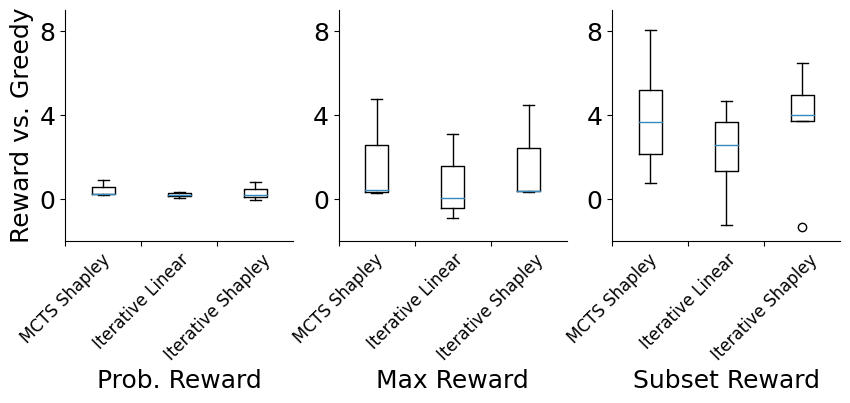

In [163]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

method_names = ['mcts_shapley','iterative_whittle','shapley_iterative_whittle']
nice_names = ["MCTS Shapley","Iterative Linear","Iterative Shapley"]

probability_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 10//2,'n_arms': 10, 'arm_set_low': 0, 'arm_set_high': 1}
max_reward_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 10//2,'n_arms': 10, 'arm_set_high': 5}
subset_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 10//2,'n_arms': 10, 'arm_set_low': 2}

probability_data = []
max_data = []
subset_data = []

for reward_type, reward_list, reward_params in zip(["prob_reward","max_reward","subset_reward"],[probability_data,max_data,subset_data],[probability_params,max_reward_params,subset_params]):
    for i,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "reward_variation/{}".format(reward_type)

        results = get_results_matching_parameters(dataset,"",reward_params)
        reward_list.append([i['{}_reward'.format(m)][0] - i['greedy_reward'][0] for i in results])

axs[0].boxplot(probability_data)
axs[1].boxplot(max_data)
axs[2].boxplot(subset_data)

for i in range(len(axs)):
    axs[i].set_ylim([-2,9])
    axs[i].set_yticks([0,4,8])
    axs[i].set_xticks([0.5,1.5,2.5],nice_names,rotation=45,fontsize=12)

axs[0].set_xlabel("Prob. Reward")
axs[1].set_xlabel("Max Reward")
axs[2].set_xlabel("Subset Reward")
axs[0].set_ylabel("Reward vs. Greedy")
plt.savefig("../../results/figures/reward_distro.pdf",dpi=300, bbox_inches='tight')

    
#     results = aggregate_normalize_data(results,baseline="greedy")
#         score_by_n.append(results['{}_time'.format(m)][0])
#         std_by_n.append(results['{}_time'.format(m)][1])
#     probability_data.append
#     plt.plot(list(range(len(n_arms))),score_by_n,'{}--'.format(shapes[i]),color=color_palette[i],label=nice_names[i])
# plt.legend(loc="upper left")
# plt.savefig("../../results/figures/time_taken.pdf",dpi=300, bbox_inches='tight')
# plt.xticks(np.array(list(range(len(n_arms)))),n_arms)
# plt.xlabel("Number of Arms")
# plt.ylabel("Time Taken (seconds)")

Text(15.347222222222223, 0.5, 'Time Taken (seconds)')

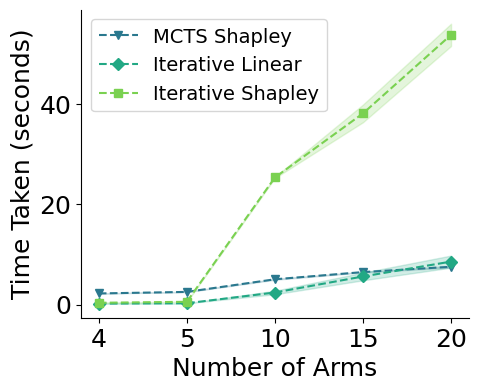

In [159]:
method_names = ['mcts_shapley','iterative_whittle','shapley_iterative_whittle']
nice_names = ["MCTS Shapley","Iterative Linear","Iterative Shapley"]
n_arms = [4,5,10,15,20]
width = 0.1
plt.figure(figsize=(5,4))
color_palette = plt.cm.viridis(np.linspace(0, 1, 6))[2:]
shapes = ['P','o','v','D','s'][2:]

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "n_k_variation"

    for n in n_arms:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': round(n/4), 'n_arms': n})
        results = aggregate_normalize_data(results,baseline="greedy")
        score_by_n.append(results['{}_time'.format(m)][0])
        std_by_n.append(results['{}_time'.format(m)][1])
    plt.fill_between(list(range(len(n_arms))), np.array(score_by_n) - np.array(std_by_n), np.array(score_by_n) + np.array(std_by_n), alpha=0.2,  color=color_palette[i])
    plt.plot(list(range(len(n_arms))),score_by_n,'{}--'.format(shapes[i]),color=color_palette[i],label=nice_names[i])
plt.legend(loc="upper left")
plt.savefig("../../results/figures/time_taken.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(n_arms)))),n_arms)
plt.xlabel("Number of Arms")
plt.ylabel("Time Taken (seconds)")

### Food Rescue

Text(-21.02777777777778, 0.5, 'Reward vs. Greedy')

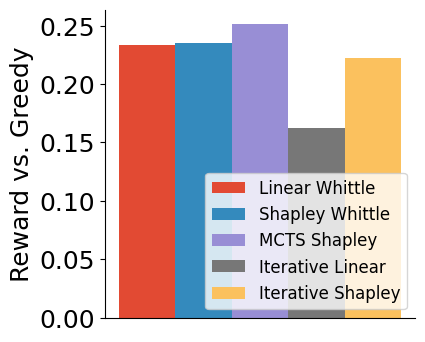

In [158]:
method_names = ['linear_whittle','shapley_whittle_custom','mcts_shapley','iterative_whittle','shapley_iterative_whittle']
nice_names = ["Linear Whittle","Shapley Whittle","MCTS Shapley","Iterative Linear","Iterative Shapley"]
n_arms = [10]
width = 0.1
plt.figure(figsize=(4,4))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "food_rescue_policies"

    for n in n_arms:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': n//2, 'n_arms': n})
        results = aggregate_normalize_data(results,baseline="greedy")
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(n_arms))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend(loc="lower right",fontsize=12)
plt.savefig("../../results/figures/food_rescue_n.pdf",dpi=300, bbox_inches='tight')
plt.xticks([])
plt.ylabel("Reward vs. Greedy")

/tmp/ipykernel_2890675/3578447341.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ratios, color="blue", shade=True)


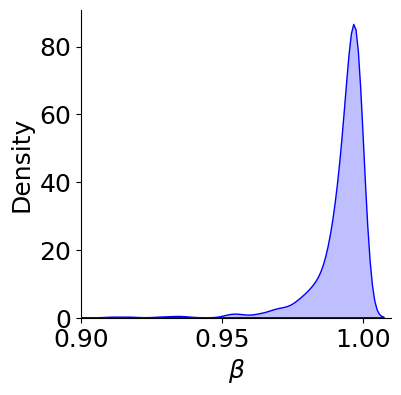

In [162]:
probs_by_user = json.load(open("../../results/food_rescue/match_probs.json","r"))
all_non_zero_probs = np.array([probs_by_user[i] for i in probs_by_user if probs_by_user[i]>0])

plt.figure(figsize=(4,4))

samples = 1000
ratios = []
for i in range(samples):
    choices = np.random.choice(list(range(len(all_non_zero_probs))),5)
    sum_probabilities = np.sum(all_non_zero_probs[choices])
    actual_prob = 1
    for prob in all_non_zero_probs[choices]:
        actual_prob *= (1-prob)
    actual_prob = 1-actual_prob
    ratios.append(actual_prob/sum_probabilities)
sns.kdeplot(ratios, color="blue", shade=True)
plt.xticks([0.9,0.95,1.0])
plt.xlim([0.9,1.01])
plt.xlabel("$\\beta$")
plt.savefig("../../results/figures/food_rescue_distro.pdf",dpi=300, bbox_inches='tight')


### Ablations

#### Food Rescue Exploration

/tmp/ipykernel_2976676/1690717028.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


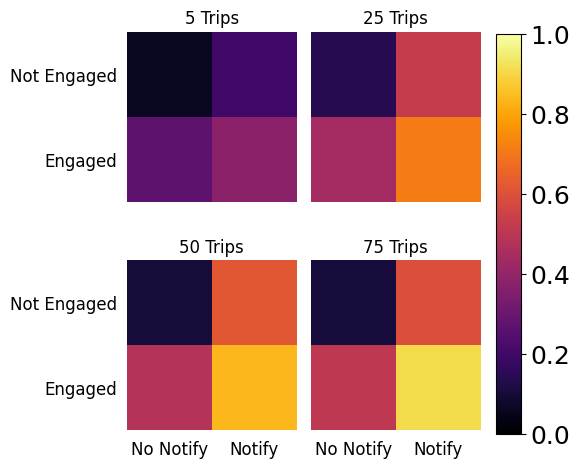

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
all_population_size = 100 
all_transitions = get_all_transitions(all_population_size)
vmax=  1
vmin = 0

transition_sizes = [[3,23],[48,73]]

for i in range(2):
    for j in range(2):
        a = axs[i,j].imshow(all_transitions[transition_sizes[i][j],:,:,1],cmap='inferno',vmax=vmax,vmin=vmin)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].set_title("{} Trips".format(transition_sizes[i][j]+2))

        if i == 1:
            axs[i,j].set_xticks([0,1],['No Notify','Notify'],fontsize=12)
        
        if j == 0:
            axs[i,j].set_yticks([0,1],['Not Engaged','Engaged'],fontsize=12)
        axs[i,j].spines['right'].set_visible(False)
        axs[i,j].spines['top'].set_visible(False)
        axs[i,j].spines['left'].set_visible(False)
        axs[i,j].spines['bottom'].set_visible(False)
        axs[i,j].tick_params(left=False,bottom=False)

# fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([1, 0.1, 0.05, 0.8])
fig.colorbar(a, cax=cbar_ax)

# Adjust layout
plt.tight_layout()
plt.savefig("../../results/figures/transition_distro_food_rescue.pdf",dpi=300, bbox_inches='tight')


/tmp/ipykernel_2976676/3973128081.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(all_non_zero_probs, color="blue", shade=True,gridsize=10000)


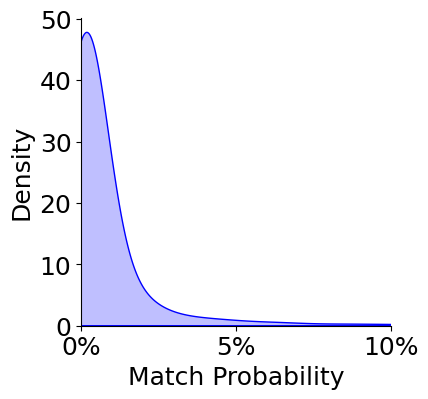

In [28]:
probs_by_user = json.load(open("../../results/food_rescue/match_probs.json","r"))
all_non_zero_probs = np.array([probs_by_user[i] for i in probs_by_user if probs_by_user[i]>0])

plt.figure(figsize=(4,4))

sns.kdeplot(all_non_zero_probs, color="blue", shade=True,gridsize=10000)
plt.xlim([0.0,0.1])
plt.xticks([0,0.05,0.1],['0%','5%','10%'])
plt.xlabel("Match Probability")
plt.savefig("../../results/figures/food_rescue_match_distro.pdf",dpi=300, bbox_inches='tight')


#### Other Ablation

Text(19.847222222222214, 0.5, 'Reward vs. Greedy')

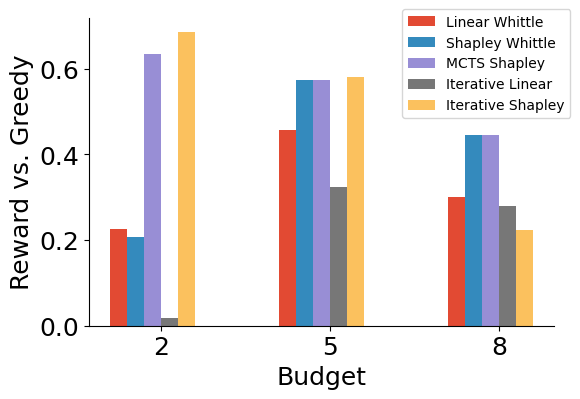

In [45]:
method_names = ['linear_whittle','shapley_whittle_custom','mcts_shapley','iterative_whittle','shapley_iterative_whittle']
nice_names = ["Linear Whittle","Shapley Whittle","MCTS Shapley","Iterative Linear","Iterative Shapley"]
budgets = [10//4,10//2,round(10*0.75)]
width = 0.1
plt.figure(figsize=(6,4))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "n_k_variation"

    for b in budgets:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': b, 'n_arms': 10})
        results = aggregate_normalize_data(results,baseline="greedy")
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(budgets))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend(loc="upper right",fontsize=10,bbox_to_anchor=(1.05,1.05))
plt.savefig("../../results/figures/budget.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(budgets))))+width*len(method_names)/2,budgets)
plt.xlabel("Budget")
plt.ylabel("Reward vs. Greedy")

Text(-1.152777777777784, 0.5, 'Reward vs. Greedy')

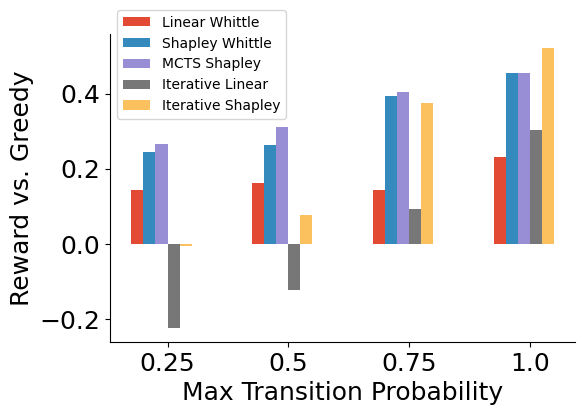

In [12]:
method_names = ['linear_whittle','shapley_whittle_custom','mcts_shapley','iterative_whittle','shapley_iterative_whittle']
nice_names = ["Linear Whittle","Shapley Whittle","MCTS Shapley","Iterative Linear","Iterative Shapley"]
min_prob = [0.25,0.5,0.75,1.0]
width = 0.1
plt.figure(figsize=(6,4))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "baselines/synthetic_transitions"

    for prob in min_prob:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 5, 'n_arms': 10, 'max_prob': prob})
        results = aggregate_normalize_data(results,baseline="greedy")
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(min_prob))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend(loc="upper left",fontsize=10,bbox_to_anchor=(0,1.1))
plt.savefig("../../results/figures/synthetic_transition.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(min_prob))))+width*len(method_names)/2,min_prob)
plt.xlabel("Max Transition Probability")
plt.ylabel("Reward vs. Greedy")

Text(93.72222222222221, 0.5, 'Reward')

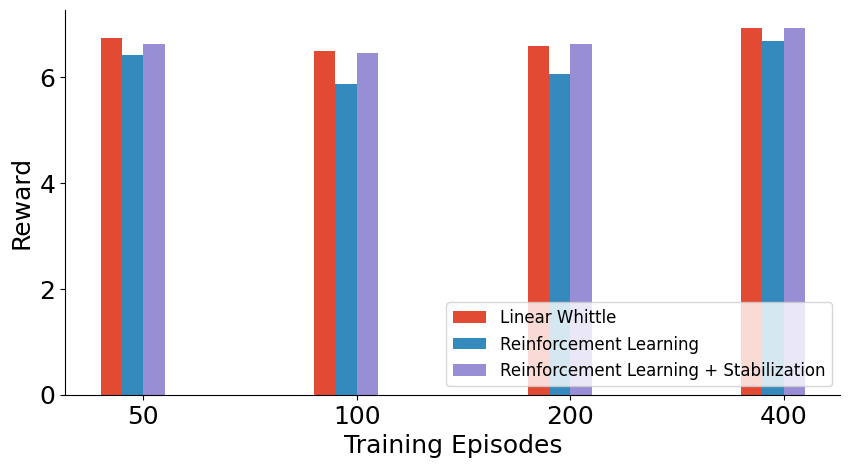

In [74]:
method_names = ["linear_whittle",'dqn_step','dqn_stable_step']
nice_names = ["Linear Whittle","Reinforcement Learning","Reinforcement Learning + Stabilization"]
n_episodes = [50,100,200,400]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "baselines/mcts"

    for n_episode in n_episodes:
        results_raw = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'budget': 5, 'n_arms': 10, 'n_episodes': n_episode})
        params = results_raw[0]['parameters']
        results = aggregate_data(results_raw)
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(n_episodes))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend(loc="lower right",fontsize=12)
plt.xticks(np.array(list(range(len(n_episodes))))+width*len(method_names)/2,n_episodes)
plt.xlabel("Training Episodes")
plt.savefig("../../results/figures/dqn_ablation.pdf",dpi=300, bbox_inches='tight')
plt.ylabel("Reward")

Text(93.72222222222221, 0.5, 'Reward')

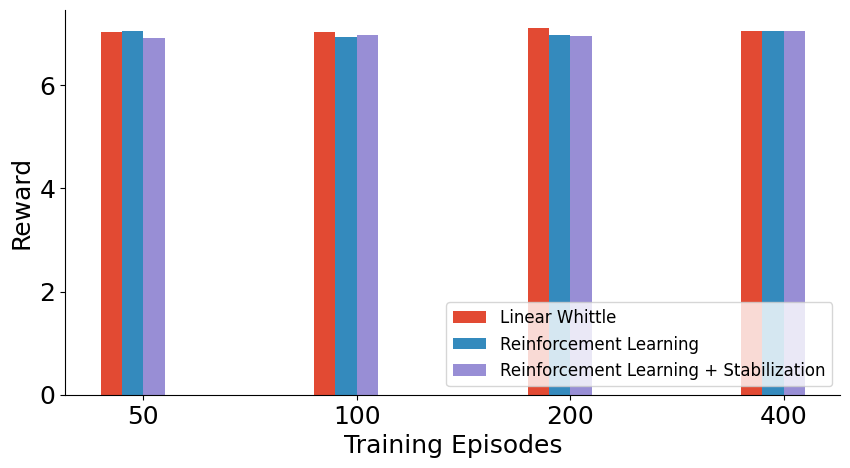

In [75]:
method_names = ["linear_whittle",'dqn_step','dqn_stable_step']
nice_names = ["Linear Whittle","Reinforcement Learning","Reinforcement Learning + Stabilization"]
n_episodes = [50,100,200,400]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "baselines/mcts"

    for n_episode in n_episodes:
        results_raw = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'budget': 25//2, 'n_arms': 25, 'n_episodes': n_episode})
        params = results_raw[0]['parameters']
        results = aggregate_data(results_raw)
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(n_episodes))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend(loc="lower right",fontsize=12)
plt.xticks(np.array(list(range(len(n_episodes))))+width*len(method_names)/2,n_episodes)
plt.xlabel("Training Episodes")
plt.savefig("../../results/figures/dqn_ablation_2.pdf",dpi=300, bbox_inches='tight')
plt.ylabel("Reward")

Text(48.847222222222214, 0.5, 'Reward vs. Greedy')

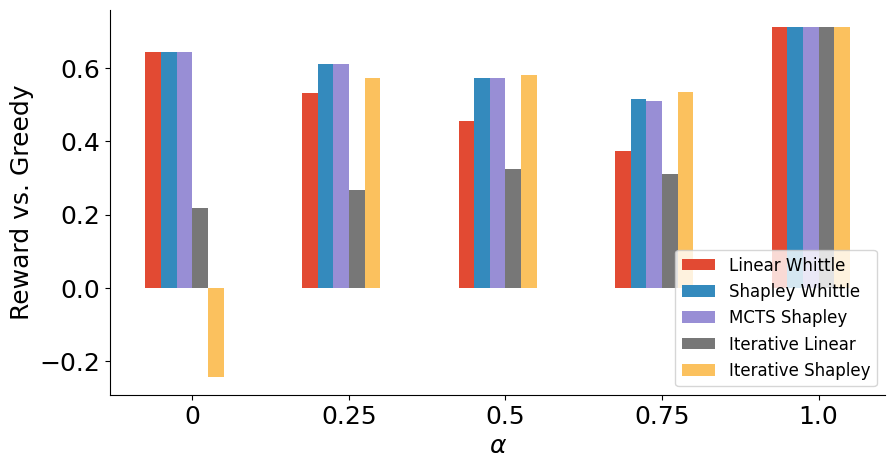

In [18]:
method_names = ['linear_whittle','shapley_whittle_custom','mcts_shapley','iterative_whittle','shapley_iterative_whittle']
nice_names = ["Linear Whittle","Shapley Whittle","MCTS Shapley","Iterative Linear","Iterative Shapley"]
lamb_values = [0,0.25,0.5,0.75,1.0]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "n_k_variation"

    for lamb in lamb_values:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': lamb, 'budget': 5, 'n_arms': 10})
        results = aggregate_normalize_data(results,baseline="greedy")
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(lamb_values))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend(loc="lower right",fontsize=12)
plt.savefig("../../results/figures/budget.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(lamb_values))))+width*len(method_names)/2,lamb_values)
plt.xlabel("$\\alpha$")
plt.ylabel("Reward vs. Greedy")

Text(69.84722222222221, 0.5, 'Reward vs. Greedy')

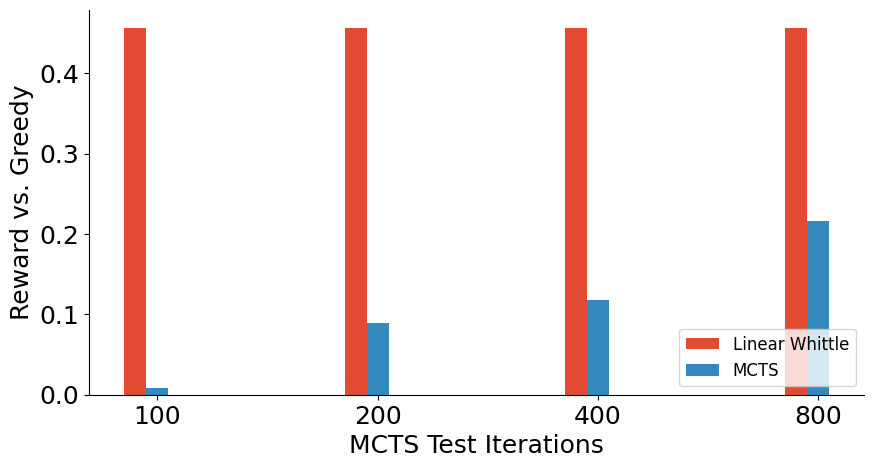

In [54]:
method_names = ['linear_whittle','mcts']
nice_names = ["Linear Whittle","MCTS"]
mcts_iterations = [100,200,400,800]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "baselines/mcts"

    for test_iterations in mcts_iterations:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'budget': 5, 'n_arms': 10, 'mcts_depth': 2, 'test_iterations': test_iterations})
        results = aggregate_normalize_data(results,baseline="greedy")
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(mcts_iterations))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend(loc="lower right",fontsize=12)
plt.savefig("../../results/figures/mcts_iterations.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(mcts_iterations))))+width*len(method_names)/2,mcts_iterations)
plt.xlabel("MCTS Test Iterations")
plt.ylabel("Reward vs. Greedy")

Text(69.84722222222221, 0.5, 'Reward vs. Greedy')

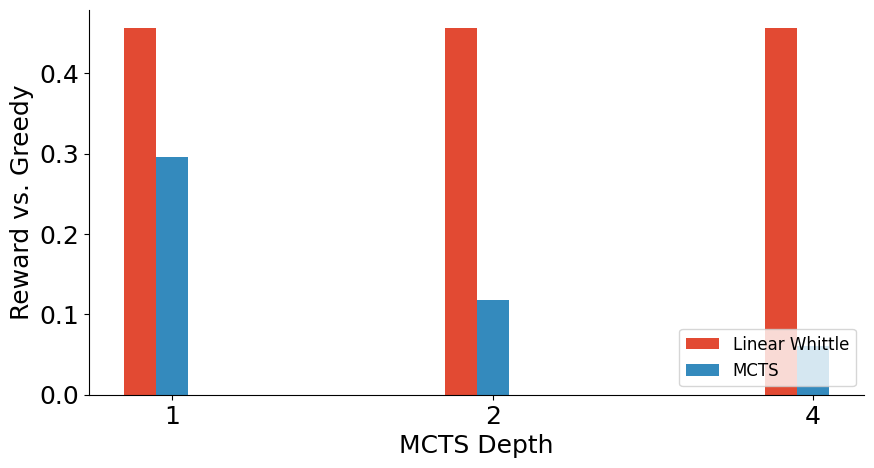

In [55]:
method_names = ['linear_whittle','mcts']
nice_names = ["Linear Whittle","MCTS"]
mcts_depth = [1,2,4]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "baselines/mcts"

    for depth in mcts_depth:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'budget': 5, 'n_arms': 10, 'mcts_depth': depth, 'test_iterations': 400})
        results = aggregate_normalize_data(results,baseline="greedy")
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(mcts_depth))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend(loc="lower right",fontsize=12)
plt.savefig("../../results/figures/mcts_depth.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(mcts_depth))))+width*len(method_names)/2,mcts_depth)
plt.xlabel("MCTS Depth")
plt.ylabel("Reward vs. Greedy")

In [60]:
seed = 42
reward_parameters = {'universe_size': 20, 'arm_set_low': 0, 'arm_set_high': 1}
n_arms = 10
prob_distro = "uniform"
reward_type = "max"

def find_match_probabilities(seed,reward_parameters,n_arms,prob_distro,reward_type):
    n_episodes = 1
    episode_len = 50
    lamb = 0.5
    all_population_size = 100 
    volunteers_per_arm = 1
    n_epochs = 1
    budget = 1
    discount = 0.9 
    n_states = 2
    all_transitions = get_all_transitions(all_population_size)

    def create_environment(seed):
        random.seed(seed)
        np.random.seed(seed)

        all_features = np.arange(all_population_size)
        N = all_population_size*volunteers_per_arm
        if reward_type == "set_cover":
            if prob_distro == "fixed":
                match_probabilities = []
                set_sizes = [int(reward_parameters['arm_set_low']) for i in range(N)]
                for i in range(N):
                    s = set() 
                    while len(s) < set_sizes[i]:
                        s.add(np.random.randint(0,reward_parameters['universe_size']))
                    match_probabilities.append(s)
            else:
                set_sizes = [np.random.poisson(int(reward_parameters['arm_set_low'])) for i in range(N)]
                match_probabilities = [set([np.random.randint(0,reward_parameters['universe_size']) for _ in range(set_sizes[i])]) for i in range(N)]
        else:
            match_probabilities = [np.random.uniform(reward_parameters['arm_set_low'],reward_parameters['arm_set_high']) for i in range(N)]

        simulator = RMABSimulator(all_population_size, all_features, all_transitions,
                    n_arms, volunteers_per_arm, episode_len, n_epochs, n_episodes, budget, discount,number_states=n_states, reward_style='custom',match_probability_list=match_probabilities)
        simulator.reward_type = reward_type 
        simulator.reward_parameters = reward_parameters 
        return simulator 

    def run_multi_seed(seed_list,policy,is_mcts=False,per_epoch_function=None,train_iterations=0,test_iterations=0,test_length=20):
        memories = []
        scores = {
            'reward': [],
            'time': [], 
            'match': [], 
            'active_rate': [],
        }

        for seed in seed_list:
            simulator = create_environment(seed)

            if is_mcts:
                simulator.mcts_train_iterations = train_iterations
                simulator.mcts_test_iterations = test_iterations
                simulator.policy_lr = 0
                simulator.value_lr = 0

            if is_mcts:
                match, active_rate, memory = run_heterogenous_policy(simulator, n_episodes, n_epochs, discount,policy,seed,lamb=lamb,should_train=True,test_T=test_length,get_memory=True,per_epoch_function=per_epoch_function)
            else:
                match, active_rate = run_heterogenous_policy(simulator, n_episodes, n_epochs, discount,policy,seed,lamb=lamb,should_train=True,test_T=test_length,per_epoch_function=per_epoch_function)

        return simulator

    simulator = run_multi_seed([seed],random_policy,test_length=n_episodes*episode_len)
    return np.array(simulator.match_probability_list)[simulator.agent_idx]

In [66]:
def get_lower_bound(seed,reward_parameters,n_arms,prob_distro,reward_type,budget):
    match_probability_list = find_match_probabilities(seed,reward_parameters,n_arms,prob_distro,reward_type)
    weights = [custom_reward(one_hot(i,n_arms),one_hot(i,n_arms),match_probability_list,reward_type,reward_parameters) for i in range(n_arms)]
    weights = np.array(weights)

    smallest_ratio = 1

    for b in range(2,budget+1):
        for combo in itertools.combinations(list(range(n_arms)),b):
            state = np.zeros((n_arms))
            combo = list(combo)
            state[combo] = 1

            denom = np.sum(weights[combo])
            numerator = custom_reward(state,state,match_probability_list,reward_type,reward_parameters)
            smallest_ratio = min(numerator/denom,smallest_ratio)
    print("Smallest ratio {} budget {}".format(smallest_ratio,budget))

    return smallest_ratio

In [67]:
get_lower_bound(seed,reward_parameters,n_arms,prob_distro,reward_type,5)

acting should always be good! (0, 1) 0.108 < 0.183
good start state should always be good! 0.380 < 0.508
good start state should always be good! 0.506 < 0.760
cohort [33  6 90 85 13  7 20 88  9 74]
Took 0.015850305557250977 time for inference and 0.0003705024719238281 time for training
Smallest ratio 0.23046840944086802 budget 5


0.23046840944086802

acting should always be good! (0, 1) 0.108 < 0.183
good start state should always be good! 0.380 < 0.508
good start state should always be good! 0.506 < 0.760
cohort [35  4 66  7]
Took 0.008658885955810547 time for inference and 0.00020384788513183594 time for training
Smallest ratio 1 budget 1
acting should always be good! (0, 1) 0.108 < 0.183
good start state should always be good! 0.380 < 0.508
good start state should always be good! 0.506 < 0.760
cohort [55 38 69 53]
Took 0.007916927337646484 time for inference and 0.00020265579223632812 time for training
Smallest ratio 1 budget 1
acting should always be good! (0, 1) 0.108 < 0.183
good start state should always be good! 0.380 < 0.508
good start state should always be good! 0.506 < 0.760
cohort [87 53 47  7]
Took 0.004944324493408203 time for inference and 0.00015234947204589844 time for training
Smallest ratio 1 budget 1
acting should always be good! (0, 1) 0.108 < 0.183
good start state should always be good! 0.380 < 0.508
good st

Text(93.72222222222221, 0.5, 'Reward')

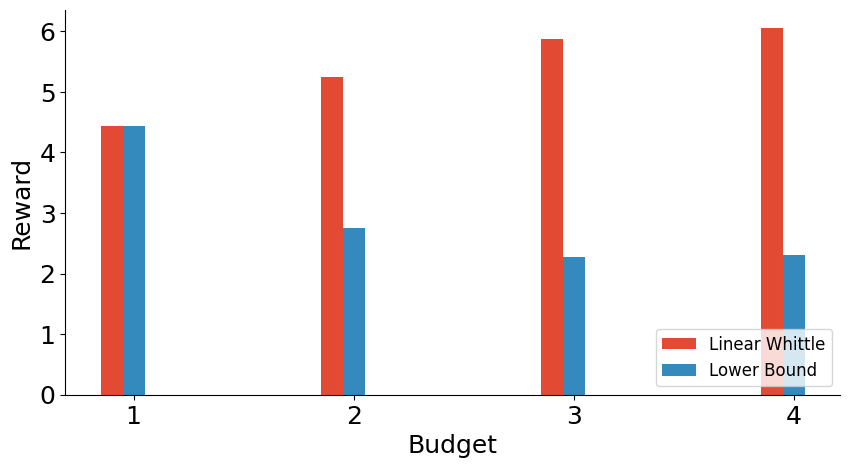

In [69]:
method_names = ["linear_whittle",'lower_bound']
nice_names = ["Linear Whittle","Lower Bound"]
budget = [1,2,3,4]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "n_k_variation"

    for b in budget:
        results_raw = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'budget': b, 'n_arms': 4})
        params = results_raw[0]['parameters']
        results = aggregate_data(results_raw)
        if '{}_reward'.format(m) not in results:
            lower_bounds = [get_lower_bound(seed,{'universe_size': params['universe_size'],'arm_set_high':params['arm_set_high'] ,'arm_set_low': params['arm_set_low']}, params['n_arms'],params['prob_distro'],params['reward_type'],params['budget'])*results_raw[j]['optimal_reward'][0] for j,seed in enumerate([i['parameters']['seed'] for i in results_raw])]
            results['{}_reward'.format(m)] = [np.mean(lower_bounds),np.std(lower_bounds)]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(budget))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend(loc="lower right",fontsize=12)
plt.xticks(np.array(list(range(len(budget))))+width*len(method_names)/2,budget)
plt.xlabel("Budget")
plt.savefig("../../results/figures/lower_bounds.pdf",dpi=300, bbox_inches='tight')
plt.ylabel("Reward")

### Baseline Plots

Text(69.84722222222221, 0.5, 'Total Reward')

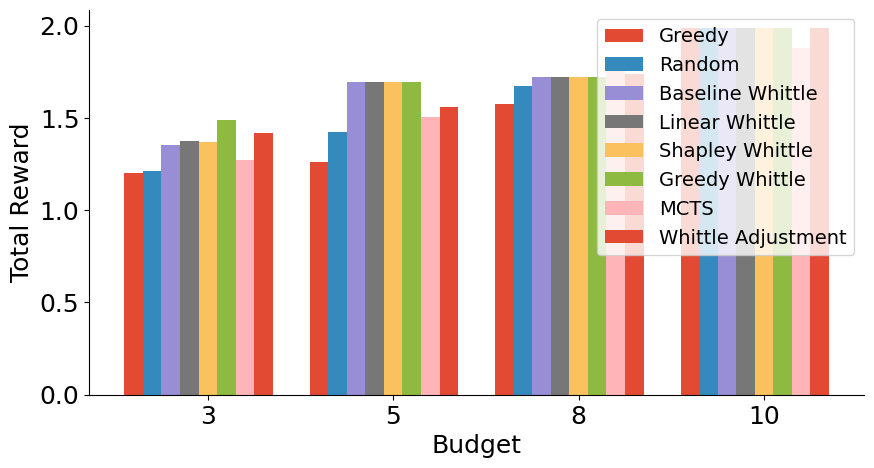

In [10]:
method_names = ['greedy','random','engagement_whittle','linear_whittle','shapley_whittle','greedy_whittle','mcts','linear_whittle_adjsuted']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle","MCTS","Whittle Adjustment"]
budgets = [3,5,8,10]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    if m == 'mcts':
        dataset = "real_data_mcts"
    else:
        dataset = "real_data"

    for b in budgets:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 5, 'lamb': 0.5, 'budget': b, 'prob_distro': 'uniform', 'n_arms': 2})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(budgets))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/real_data_budget.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(budgets))))+width*len(method_names)/2,budgets)
plt.xlabel("Budget")
plt.ylabel("Total Reward")

Text(93.72222222222221, 0.5, 'Total Reward')

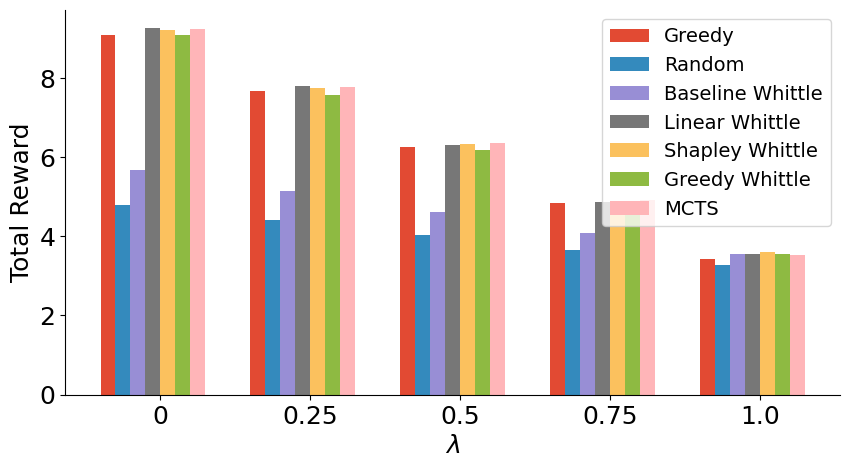

In [11]:
method_names = ['greedy','random','engagement_whittle','linear_whittle','shapley_whittle','greedy_whittle','mcts']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle","MCTS"]
lambs = [0,0.25,0.5,0.75,1.0]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    if m == 'mcts':
        dataset = "semi_synthetic_mcts"
    else:
        dataset = "semi_synthetic"

    for lamb in lambs:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 5, 'lamb': lamb, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(lambs))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/semi_synthetic_lambda.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(lambs))))+width*len(method_names)/2,lambs)
plt.xlabel("$\lambda$")
plt.ylabel("Total Reward")

Text(69.84722222222221, 0.5, 'Total Reward')

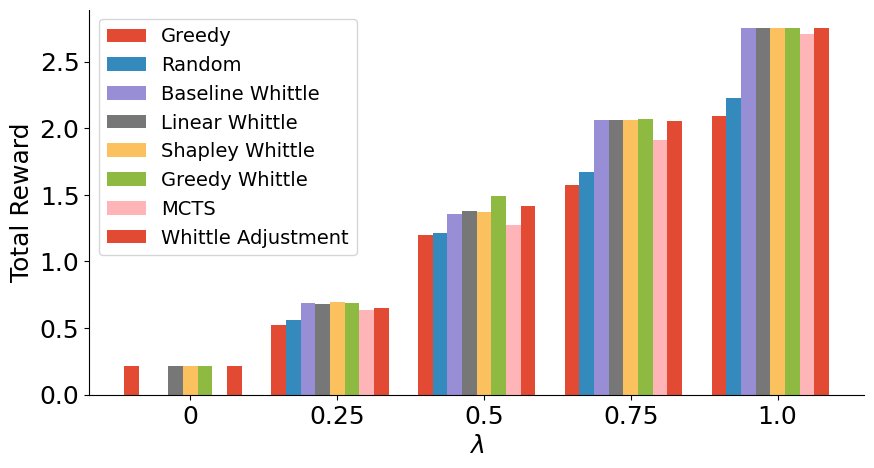

In [12]:
method_names = ['greedy','random','engagement_whittle','linear_whittle','shapley_whittle','greedy_whittle','mcts','linear_whittle_adjsuted']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle","MCTS","Whittle Adjustment"]
lambs = [0,0.25,0.5,0.75,1.0]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    if m == 'mcts':
        dataset = "real_data_mcts"
    else:
        dataset = "real_data"

    for lamb in lambs:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 5, 'lamb': lamb, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(lambs))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/real_data_lambda.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(lambs))))+width*len(method_names)/2,lambs)
plt.xlabel("$\lambda$")
plt.ylabel("Total Reward")

Text(93.72222222222221, 0.5, 'Total Reward')

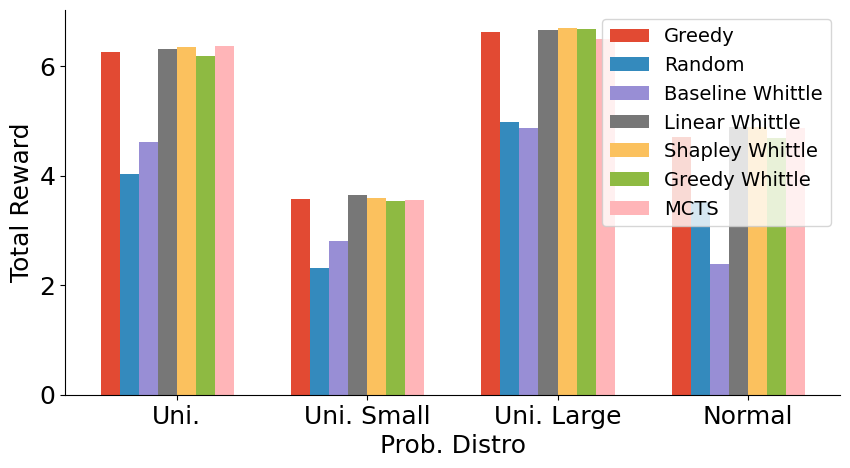

In [13]:
method_names = ['greedy','random','engagement_whittle','linear_whittle','shapley_whittle','greedy_whittle','mcts']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle","MCTS"]
distros = ['uniform','uniform_small','uniform_large','normal']
distro_nice = ['Uni.','Uni. Small','Uni. Large','Normal']
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    if m == 'mcts':
        dataset = "semi_synthetic_mcts"
    else:
        dataset = "semi_synthetic"

    for d in distros:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 5, 'lamb': 0.5, 'budget': 3, 'prob_distro': d, 'n_arms': 2})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(distros))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/semi_synthetic_distros.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(distros))))+width*len(method_names)/2,distro_nice)
plt.xlabel("Prob. Distro")
plt.ylabel("Total Reward")

## MCTS + Shapley

Text(77.84722222222221, 0.5, 'Total Reward')

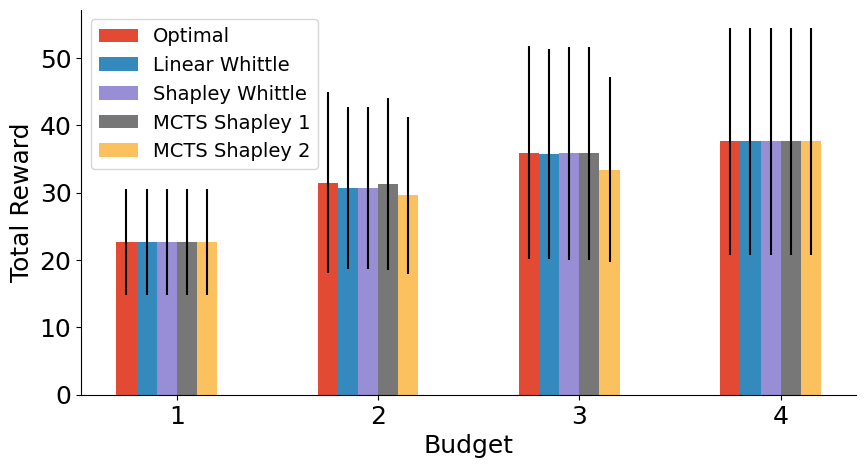

In [8]:
method_names = ['optimal','linear_whittle','shapley_whittle_custom','mcts_shapley','mcts_shapley_attribution']
nice_names = ["Optimal","Linear Whittle","Shapley Whittle","MCTS Shapley 1","MCTS Shapley 2"]
budgets = [1,2,3,4]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "mcts_exploration/mcts_shapley"

    for b in budgets:
        results = get_results_matching_parameters("mcts_exploration/mcts_shapley","",{'volunteers_per_arm': 2, 'lamb': 0, 'budget': b, 'n_arms': 2,'universe_size': 10, 'arm_set_low': 3, 'arm_set_high': 6})
        results = aggregate_data(results)
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(budgets))))+i*width,score_by_n,width=width,label=nice_names[i],yerr=std_by_n)
plt.legend()
plt.savefig("../../results/figures/pure_mcts_budget.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(budgets))))+width*len(method_names)/2,budgets)
plt.xlabel("Budget")
plt.ylabel("Total Reward")

[{'parameters': {'seed': 43, 'n_arms': 2, 'volunteers_per_arm': 5, 'budget': 2, 'discount': 0.9, 'alpha': 3, 'n_episodes': 5, 'episode_len': 20, 'n_epochs': 1, 'lamb': 0.0, 'time_per_run': 10.0, 'prob_distro': 'uniform', 'policy_lr': 0.005, 'value_lr': 0.0001, 'reward_type': 'set_cover', 'universe_size': 10, 'arm_set_low': 3, 'arm_set_high': 6}, 'linear_whittle_reward': [56.95926677874421], 'linear_whittle_match': [6.54], 'linear_whittle_active': [0.22799999999999998], 'linear_whittle_time': [0.4105417728424072], 'shapley_whittle_custom_reward': [57.37362982913063], 'shapley_whittle_custom_match': [6.6], 'shapley_whittle_custom_active': [0.22899999999999998], 'shapley_whittle_custom_time': [0.586245059967041], 'mcts_shapley_reward': [58.814322765619806], 'mcts_shapley_match': [6.64], 'mcts_shapley_active': [0.22400000000000003], 'mcts_shapley_time': [17.75584840774536], 'mcts_shapley_attribution_reward': [56.138967182902036], 'mcts_shapley_attribution_match': [6.29], 'mcts_shapley_attr

Text(49.097222222222214, 0.5, 'Total Reward')

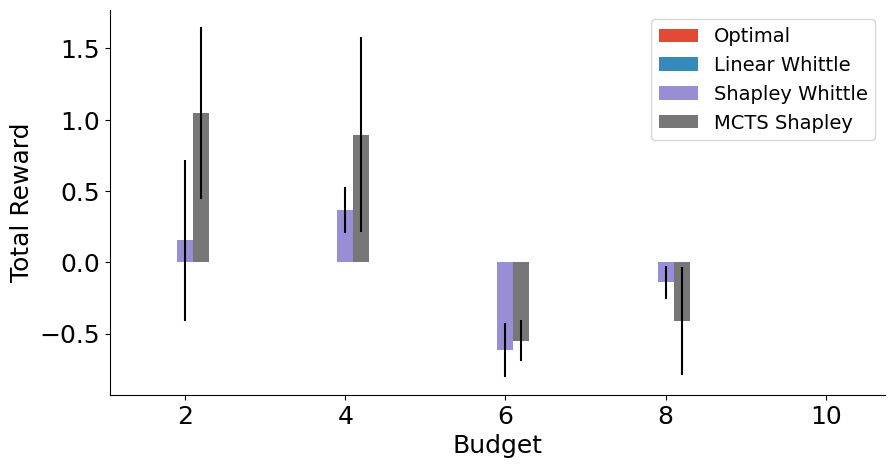

In [10]:
method_names = ['optimal','linear_whittle','shapley_whittle_custom','mcts_shapley']
nice_names = ["Optimal","Linear Whittle","Shapley Whittle","MCTS Shapley"]
budgets = [2,4,6,8,10]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "mcts_exploration/mcts_shapley"

    for b in budgets:
        results = get_results_matching_parameters("mcts_exploration/mcts_shapley","",{'volunteers_per_arm': 5, 'lamb': 0, 'budget': b, 'n_arms': 2,'universe_size': 10, 'arm_set_low': 3, 'arm_set_high': 6})
        print(results)
        results = aggregate_normalize_data(results)
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(budgets))))+i*width,score_by_n,width=width,label=nice_names[i],yerr=std_by_n)
plt.legend()
plt.savefig("../../results/figures/pure_mcts_budget.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(budgets))))+width*len(method_names)/2,budgets)
plt.xlabel("Budget")
plt.ylabel("Total Reward")

1 [{'parameters': {'seed': 44, 'n_arms': 2, 'volunteers_per_arm': 2, 'budget': 2, 'discount': 0.9, 'alpha': 3, 'n_episodes': 5, 'episode_len': 20, 'n_epochs': 1, 'lamb': 0.0, 'time_per_run': 10.0, 'prob_distro': 'uniform', 'policy_lr': 0.005, 'value_lr': 0.0001, 'reward_type': 'set_cover', 'universe_size': 10, 'arm_set_low': 1, 'arm_set_high': 5}, 'linear_whittle_reward': [48.9076508913568], 'linear_whittle_match': [5.6], 'linear_whittle_active': [0.44], 'linear_whittle_time': [0.2382674217224121], 'optimal_reward': [48.9076508913568], 'optimal_match': [5.6], 'optimal_active': [0.44], 'optimal_time': [0.009567737579345703], 'shapley_whittle_custom_reward': [48.9076508913568], 'shapley_whittle_custom_match': [5.6], 'shapley_whittle_custom_active': [0.44], 'shapley_whittle_custom_time': [0.2537558078765869], 'mcts_shapley_reward': [48.9076508913568], 'mcts_shapley_match': [5.6], 'mcts_shapley_active': [0.44], 'mcts_shapley_time': [8.082322835922241], 'mcts_shapley_attribution_reward': [4

Text(48.972222222222214, 0.5, 'Total Reward')

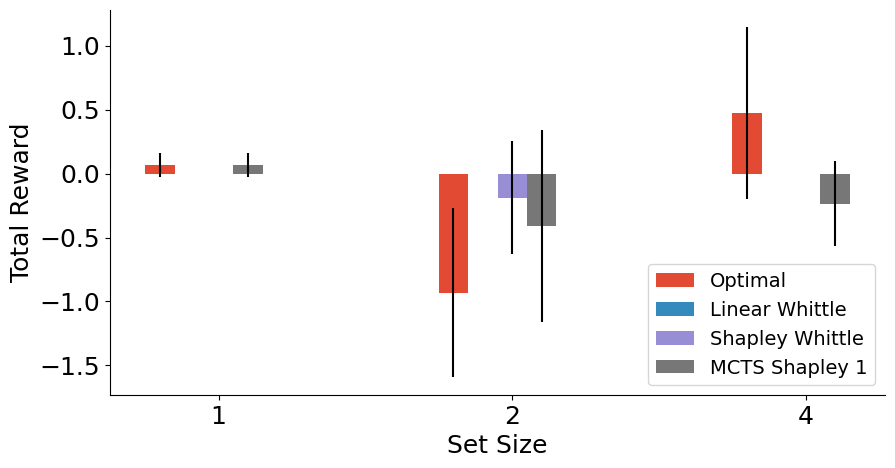

In [11]:
method_names = ['optimal','linear_whittle','shapley_whittle_custom','mcts_shapley']
nice_names = ["Optimal","Linear Whittle","Shapley Whittle","MCTS Shapley 1"]
arm_small = [1,2,4]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "mcts_exploration/mcts_shapley"

    for b in arm_small:
        results = get_results_matching_parameters("mcts_exploration/mcts_shapley","",{'volunteers_per_arm': 2, 'lamb': 0, 'budget': 2, 'n_arms': 2,'universe_size': 10, 'arm_set_low': b, 'arm_set_high': 5})
        print(b,results)
        results = aggregate_normalize_data(results)
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(arm_small))))+i*width,score_by_n,width=width,label=nice_names[i],yerr=std_by_n)
plt.legend(loc="lower right")
plt.savefig("../../results/figures/pure_mcts_budget.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(arm_small))))+width*len(method_names)/2,arm_small)
plt.xlabel("Set Size")
plt.ylabel("Total Reward")

Text(69.84722222222221, 0.5, 'Total Reward')

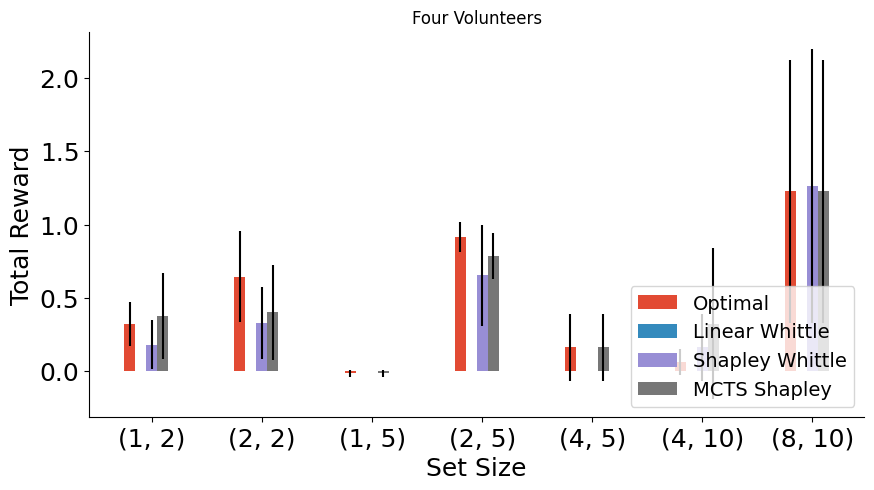

In [12]:
method_names = ['optimal','linear_whittle','shapley_whittle_custom','mcts_shapley']
nice_names = ["Optimal","Linear Whittle","Shapley Whittle","MCTS Shapley"]
low_high_combos = [(1,2),(2,2),(1,5),(2,5),(4,5),(4,10),(8,10)]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "mcts_exploration/mcts_shapley"

    for l,h in low_high_combos:
        results = get_results_matching_parameters("mcts_exploration/mcts_shapley","",{'volunteers_per_arm': 2, 'lamb': 0, 'budget': 2, 'n_arms': 2,'universe_size': 20, 'arm_set_low': l, 'arm_set_high': h})
        results = aggregate_normalize_data(results)
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(low_high_combos))))+i*width,score_by_n,width=width,label=nice_names[i],yerr=std_by_n)
plt.title("Four Volunteers")
plt.legend(loc="lower right")
plt.savefig("../../results/figures/pure_mcts_budget.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(low_high_combos))))+width*len(method_names)/2,low_high_combos)
plt.xlabel("Set Size")
plt.ylabel("Total Reward")

Text(93.72222222222221, 0.5, 'Total Reward')

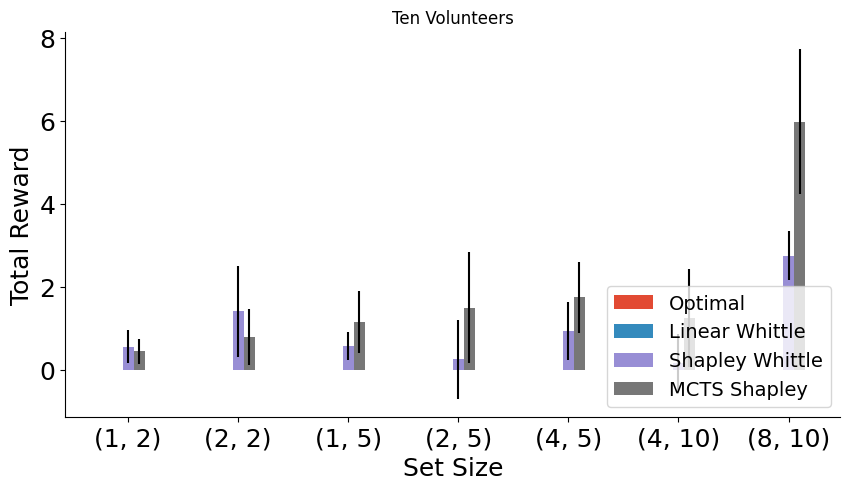

In [15]:
method_names = ['optimal','linear_whittle','shapley_whittle_custom','mcts_shapley']
nice_names = ["Optimal","Linear Whittle","Shapley Whittle","MCTS Shapley"]
low_high_combos = [(1,2),(2,2),(1,5),(2,5),(4,5),(4,10),(8,10)]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "mcts_exploration/mcts_shapley"

    for l,h in low_high_combos:
        results = get_results_matching_parameters("mcts_exploration/mcts_shapley","",{'volunteers_per_arm': 5, 'lamb': 0, 'budget': 2, 'n_arms': 2,'universe_size': 20, 'arm_set_low': l, 'arm_set_high': h})
        results = aggregate_normalize_data(results)
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(low_high_combos))))+i*width,score_by_n,width=width,label=nice_names[i],yerr=std_by_n)
plt.legend(loc="lower right")
plt.title("Ten Volunteers")
plt.savefig("../../results/figures/pure_mcts_budget.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(low_high_combos))))+width*len(method_names)/2,low_high_combos)
plt.xlabel("Set Size")
plt.ylabel("Total Reward")

In [27]:
method_names = ['linear_whittle','shapley_whittle_custom','mcts_shapley']
nice_names = ["Linear Whittle","Shapley Whittle","MCTS Shapley"]
low_high_combos = [(1,2),(2,2),(1,5),(2,5),(4,5),(4,10),(8,10)]

for l,h in low_high_combos:
    score_by_method = {}
    dataset = "mcts_exploration/mcts_shapley"

    for i,m in enumerate(method_names):
        results = get_results_matching_parameters("mcts_exploration/mcts_shapley","",{'volunteers_per_arm': 5, 'lamb': 0, 'budget': 2, 'n_arms': 2,'universe_size': 20, 'arm_set_low': l, 'arm_set_high': h})
        results = [i['{}_reward'.format(m)] for i in results]
        score_by_method[nice_names[i]] = results 

    for m in nice_names:
        if m != "Linear Whittle":
            t_stat, p_val = stats.ttest_rel(score_by_method[m],score_by_method["Linear Whittle"])
            print("(l,h) {}: Comparing {} to Linear Whittle yields a p value of {} and a t stat of {}".format((l,h),m,p_val,t_stat))

(l,h) (1, 2): Comparing Shapley Whittle to Linear Whittle yields a p value of [0.17907299] and a t stat of [2.03309761]
(l,h) (1, 2): Comparing MCTS Shapley to Linear Whittle yields a p value of [0.16977076] and a t stat of [2.10634169]
(l,h) (2, 2): Comparing Shapley Whittle to Linear Whittle yields a p value of [0.20821488] and a t stat of [1.83325758]
(l,h) (2, 2): Comparing MCTS Shapley to Linear Whittle yields a p value of [0.23492388] and a t stat of [1.68025172]
(l,h) (1, 5): Comparing Shapley Whittle to Linear Whittle yields a p value of [0.14149785] and a t stat of [2.36755425]
(l,h) (1, 5): Comparing MCTS Shapley to Linear Whittle yields a p value of [0.16347002] and a t stat of [2.15912827]
(l,h) (2, 5): Comparing Shapley Whittle to Linear Whittle yields a p value of [0.74513238] and a t stat of [0.37274685]
(l,h) (2, 5): Comparing MCTS Shapley to Linear Whittle yields a p value of [0.25301056] and a t stat of [1.58896741]
(l,h) (4, 5): Comparing Shapley Whittle to Linear Wh

Text(49.097222222222214, 0.5, 'Total Reward')

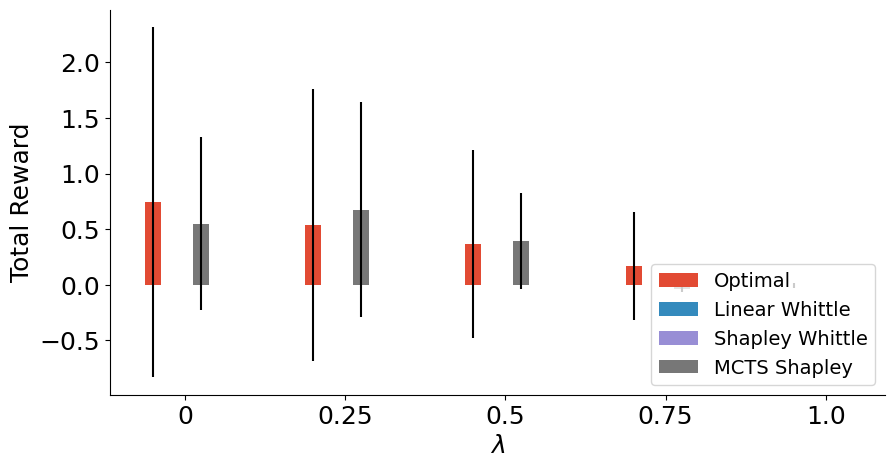

In [14]:
method_names = ['optimal','linear_whittle','shapley_whittle_custom','mcts_shapley']
nice_names = ["Optimal","Linear Whittle","Shapley Whittle","MCTS Shapley"]
lambs = [0,0.25,0.5,0.75,1.0]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "mcts_exploration/mcts_shapley"

    for l in lambs:
        results = get_results_matching_parameters("mcts_exploration/mcts_shapley","",{'volunteers_per_arm': 2, 'lamb': l, 'budget': 2, 'n_arms': 2,'universe_size': 10, 'arm_set_low': 3, 'arm_set_high': 6})
        results = aggregate_normalize_data(results)
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(lambs))))+i*width,score_by_n,width=width,label=nice_names[i],yerr=std_by_n)
plt.legend(loc="lower right")
plt.savefig("../../results/figures/pure_mcts_budget.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(lambs))))+width*len(method_names)/2,lambs)
plt.xlabel("$\lambda$")
plt.ylabel("Total Reward")

In [34]:
method_names = ['optimal','linear_whittle','shapley_whittle_custom','mcts_shapley']
nice_names = ["Optimal","Linear Whittle","Shapley Whittle","MCTS Shapley"]
lambs = [0,0.25,0.5,0.75,1.0]

for l in lambs:
    score_by_method = {}
    dataset = "mcts_exploration/mcts_shapley"

    for i,m in enumerate(method_names):
        results = get_results_matching_parameters("mcts_exploration/mcts_shapley","",{'volunteers_per_arm': 2, 'lamb': l, 'budget': 2, 'n_arms': 2,'universe_size': 10, 'arm_set_low': 3, 'arm_set_high': 6})
        results = [i['{}_reward'.format(m)][0] for i in results]
        score_by_method[nice_names[i]] = results 

    for m in nice_names:
        if m != "Linear Whittle":
            print(score_by_method[m],score_by_method["Linear Whittle"])
            if score_by_method[m] == score_by_method["Linear Whittle"]:
                t_stat = 0 
                p_val = 1.0 
            else:
                t_stat, p_val = stats.ttest_rel(score_by_method[m],score_by_method["Linear Whittle"])
            print("lambda {}: Comparing {} to Linear Whittle yields a p value of {} and a t stat of {}".format(l,m,p_val,t_stat))

[18.967753488369933, 25.256369094627555, 50.10546664152626] [18.967753488369933, 25.958236546027557, 47.176517413579674]
lambda 0: Comparing Optimal to Linear Whittle yields a p value of 0.5730870786226634 and a t stat of 0.6676444666834254
[18.967753488369933, 25.958236546027557, 47.176517413579674] [18.967753488369933, 25.958236546027557, 47.176517413579674]
lambda 0: Comparing Shapley Whittle to Linear Whittle yields a p value of 1.0 and a t stat of 0
[18.967753488369933, 25.958236546027557, 48.82879215254802] [18.967753488369933, 25.958236546027557, 47.176517413579674]
lambda 0: Comparing MCTS Shapley to Linear Whittle yields a p value of 0.42264973081037427 and a t stat of 0.9999999999999998
[19.598678713141776, 38.61290831024411, 14.63119153634232] [20.219351259371642, 36.383209848052225, 14.63119153634232]
lambda 0.25: Comparing Optimal to Linear Whittle yields a p value of 0.59862518749337 and a t stat of 0.6197413398929813
[20.212333407982037, 36.383209848052225, 14.6311915363

## Iterative and MCTS Runs

Text(56.847222222222214, 0.5, 'Regret (vs. Linear Whit.)')

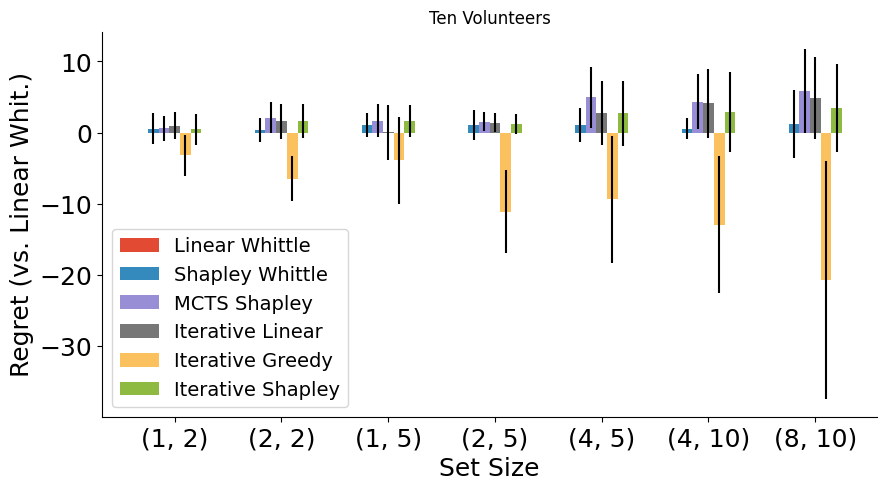

In [23]:
method_names = ['linear_whittle','shapley_whittle_custom','mcts_shapley','iterative_whittle','greedy_iterative_whittle','shapley_iterative_whittle']
nice_names = ["Linear Whittle","Shapley Whittle","MCTS Shapley","Iterative Linear","Iterative Greedy","Iterative Shapley"]
low_high_combos = [(1,2),(2,2),(1,5),(2,5),(4,5),(4,10),(8,10)]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "iterative"

    for l,h in low_high_combos:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 5, 'lamb': 0, 'budget': 2, 'n_arms': 2,'universe_size': 20, 'arm_set_low': l, 'arm_set_high': h})
        results = aggregate_normalize_data(results)
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(low_high_combos))))+i*width,score_by_n,width=width,label=nice_names[i],yerr=std_by_n)
plt.legend(loc="lower left")
plt.title("Ten Volunteers")
plt.savefig("../../results/figures/pure_mcts_budget.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(low_high_combos))))+width*len(method_names)/2,low_high_combos)
plt.xlabel("Set Size")
plt.ylabel("Regret (vs. Linear Whit.)")

Text(77.84722222222221, 0.5, 'Time Taken')

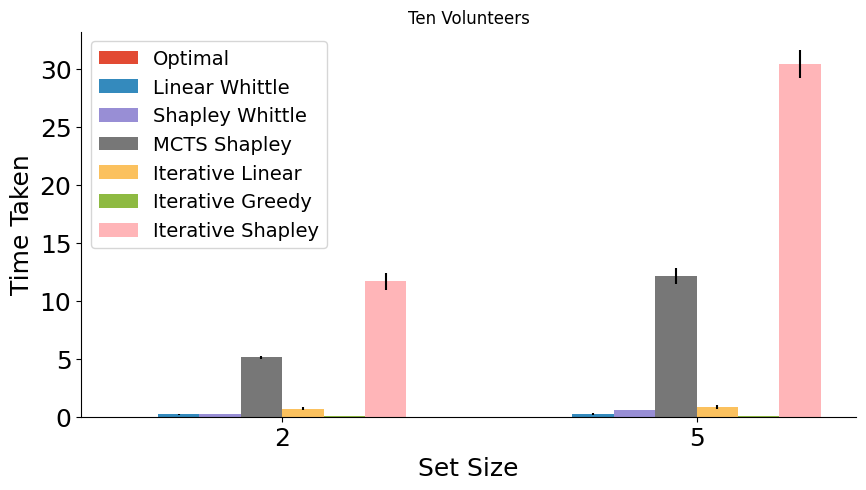

In [15]:
method_names = ['optimal','linear_whittle','shapley_whittle_custom','mcts_shapley','iterative_whittle','greedy_iterative_whittle','shapley_iterative_whittle']
nice_names = ["Optimal","Linear Whittle","Shapley Whittle","MCTS Shapley","Iterative Linear","Iterative Greedy","Iterative Shapley"]
num_volunteers = [2,5]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "iterative"

    for n in num_volunteers:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': n, 'lamb': 0, 'budget': 2, 'n_arms': 2,'universe_size': 20, 'arm_set_low': 8, 'arm_set_high': 10})
        results = aggregate_data(results)
        if '{}_time'.format(m) not in results:
            results['{}_time'.format(m)] = [0,0]
        score_by_n.append(results['{}_time'.format(m)][0])
        std_by_n.append(results['{}_time'.format(m)][1])
    plt.bar(np.array(list(range(len(num_volunteers))))+i*width,score_by_n,width=width,label=nice_names[i],yerr=std_by_n)
plt.legend(loc="upper left")
plt.title("Ten Volunteers")
plt.savefig("../../results/figures/pure_mcts_budget.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(num_volunteers))))+width*len(method_names)/2,num_volunteers)
plt.xlabel("Set Size")
plt.ylabel("Time Taken")

In [11]:
method_names = ['linear_whittle','shapley_whittle_custom','mcts_shapley','iterative_whittle','greedy_iterative_whittle','shapley_iterative_whittle']
nice_names = ["Linear Whittle","Shapley Whittle","MCTS Shapley","Iterative Linear","Iterative Greedy","Iterative Shapley"]
low_high_combos = [(1,2),(2,2),(1,5),(2,5),(4,5),(4,10),(8,10)]

for l,h in low_high_combos:
    score_by_method = {}
    dataset = "iterative"

    for i,m in enumerate(method_names):
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 5, 'lamb': 0, 'budget': 2, 'n_arms': 2,'universe_size': 20, 'arm_set_low': l, 'arm_set_high': h})
        results = [i['{}_reward'.format(m)] for i in results]
        score_by_method[nice_names[i]] = results 

    for m in nice_names:
        if m != "Linear Whittle":
            t_stat, p_val = stats.ttest_rel(score_by_method[m],score_by_method["Linear Whittle"])
            print("(l,h) {}: Comparing {} to Linear Whittle yields a p value of {} and a t stat of {}".format((l,h),m,p_val,t_stat))

(l,h) (1, 2): Comparing Shapley Whittle to Linear Whittle yields a p value of [0.48732725] and a t stat of [0.72807683]
(l,h) (1, 2): Comparing MCTS Shapley to Linear Whittle yields a p value of [0.39108087] and a t stat of [0.90665254]
(l,h) (1, 2): Comparing Iterative Linear to Linear Whittle yields a p value of [0.18921631] and a t stat of [1.43495302]
(l,h) (1, 2): Comparing Iterative Greedy to Linear Whittle yields a p value of [0.0131577] and a t stat of [-3.17186181]
(l,h) (1, 2): Comparing Iterative Shapley to Linear Whittle yields a p value of [0.60525919] and a t stat of [0.53793583]
(l,h) (2, 2): Comparing Shapley Whittle to Linear Whittle yields a p value of [0.57547324] and a t stat of [0.58375008]
(l,h) (2, 2): Comparing MCTS Shapley to Linear Whittle yields a p value of [0.02786789] and a t stat of [2.68134431]
(l,h) (2, 2): Comparing Iterative Linear to Linear Whittle yields a p value of [0.10829468] and a t stat of [1.80755613]
(l,h) (2, 2): Comparing Iterative Greedy 

## Pure RL Runs

Text(93.72222222222221, 0.5, 'Total Reward')

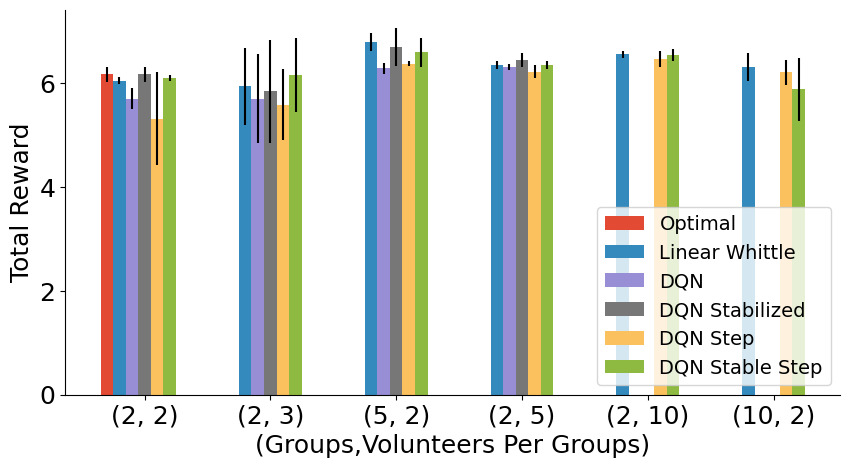

In [20]:
method_names = ['optimal','linear_whittle','dqn','dqn_stable','dqn_step','dqn_stable_step']
nice_names = ["Optimal","Linear Whittle","DQN","DQN Stabilized","DQN Step","DQN Stable Step"]
arms_volunteers = [(2,2),(2,3),(5,2),(2,5), (2,10), (10,2)]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "mcts_exploration/rl_exploration"

    for arms,volunteers in arms_volunteers:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': volunteers, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': arms})
        results = aggregate_data(results)
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = (0,0)
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(arms_volunteers))))+i*width,score_by_n,width=width,label=nice_names[i],yerr=std_by_n)
plt.legend(loc="lower right")
plt.savefig("../../results/figures/pure_rl.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(arms_volunteers))))+width*len(method_names)/2,arms_volunteers)
plt.xlabel("(Groups,Volunteers Per Groups)")
plt.ylabel("Total Reward")

Text(54.097222222222214, 0.5, 'Evaluation Time (s)')

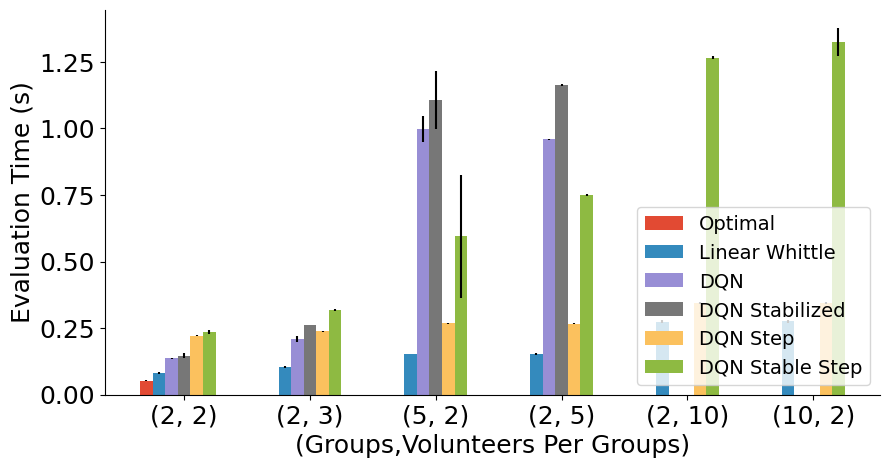

In [6]:
method_names = ['optimal','linear_whittle','dqn','dqn_stable','dqn_step','dqn_stable_step']
nice_names = ["Optimal","Linear Whittle","DQN","DQN Stabilized","DQN Step","DQN Stable Step"]
arms_volunteers = [(2,2),(2,3),(5,2),(2,5), (2,10), (10,2)]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "mcts_exploration/rl_exploration"

    for arms,volunteers in arms_volunteers:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': volunteers, 'lamb': 0.5, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': arms})
        results = aggregate_data(results)
        if '{}_time'.format(m) not in results:
            results['{}_time'.format(m)] = (0,0)
        score_by_n.append(results['{}_time'.format(m)][0])
        std_by_n.append(results['{}_time'.format(m)][1])
    plt.bar(np.array(list(range(len(arms_volunteers))))+i*width,score_by_n,width=width,label=nice_names[i],yerr=std_by_n)
plt.legend(loc="lower right")
plt.savefig("../../results/figures/pure_rl_time.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(arms_volunteers))))+width*len(method_names)/2,arms_volunteers)
plt.xlabel("(Groups,Volunteers Per Groups)")
plt.ylabel("Evaluation Time (s)")

Text(93.72222222222221, 0.5, 'Total Reward')

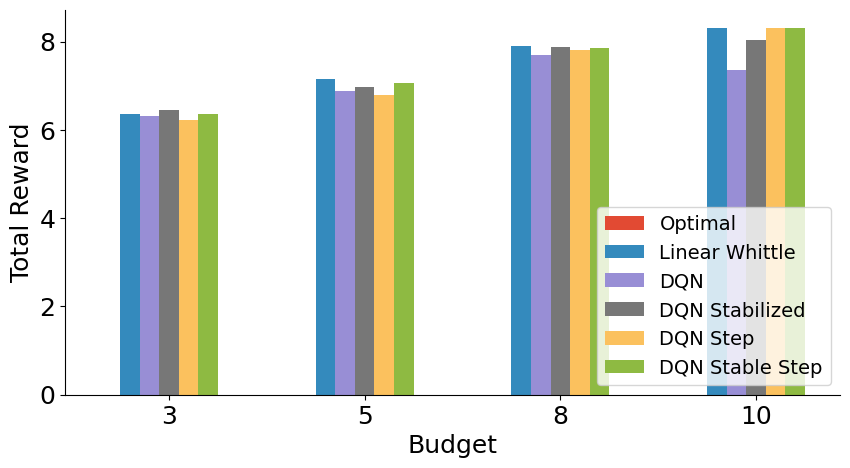

In [7]:
method_names = ['optimal','linear_whittle','dqn','dqn_stable','dqn_step','dqn_stable_step']
nice_names = ["Optimal","Linear Whittle","DQN","DQN Stabilized","DQN Step","DQN Stable Step"]
budgets = [3,5,8,10]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    dataset = "mcts_exploration/rl_exploration"

    for b in budgets:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 5, 'lamb': 0.5, 'budget': b, 'prob_distro': 'uniform', 'n_arms': 2})
        results = aggregate_data(results)
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0]
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(budgets))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend(loc="lower right")
plt.savefig("../../results/figures/pure_rl_budget.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(budgets))))+width*len(method_names)/2,budgets)
plt.xlabel("Budget")
plt.ylabel("Total Reward")

Text(93.72222222222221, 0.5, 'Total Reward')

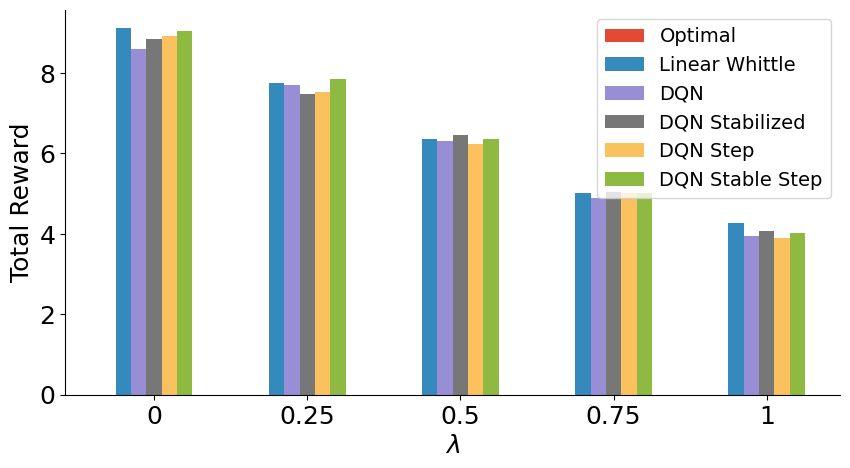

In [8]:
method_names = ['optimal','linear_whittle','dqn','dqn_stable','dqn_step','dqn_stable_step']
nice_names = ["Optimal","Linear Whittle","DQN","DQN Stabilized","DQN Step","DQN Stable Step"]
lambs = [0,0.25,0.5,0.75,1]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []

    dataset = "mcts_exploration/rl_exploration"

    for lamb in lambs:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 5, 'lamb': lamb, 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2})
        results = aggregate_data(results)
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0]
        score_by_n.append(results['{}_reward'.format(m)][0])
    plt.bar(np.array(list(range(len(lambs))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend()
plt.savefig("../../results/figures/pure_rl_lamb.pdf",dpi=300, bbox_inches='tight')
plt.xticks(np.array(list(range(len(lambs))))+width*len(method_names)/2,lambs)
plt.xlabel("$\lambda$")
plt.ylabel("Total Reward")